In [2]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import random
from time import perf_counter_ns
import threading # Too lazy to wait for simulation.

def verify_sorted(arr: List[int]) -> bool:
    for i in range(1, len(arr)):
        if arr[i-1] > arr[i]:
            return False 
    return True

RAND_SEED = 69

# Context
> In Mergesort, when the sizes of subarrays are small, the overhead of many recursive calls makes the algorithm inefficient. Therefore, in real use, we often combine Mergesort with Insertion Sort to come up with a hybrid sorting algorithm for better efficiency. The idea is to set a small integer S as a threshold for the size of subarrays. Once the size of a subarray in a recursive call of Mergesort is less than or equal to S, the algorithm will switch to Insertion Sort, which is efficient for small-sized input.

**Notes**
- `S=0` is normal merge sort
- `S -> +Inf` is insertion sort

# (a) Algorithm implementation: Implement the above hybrid algorithm

## Insertion Sort Implementation

In [3]:
def insertion_sort(arr):
    # Duplicate array cus the implementation of merge sort is not inplace.
    # This is to avoid unexpected inplace/non inplace sorting.
    arr = [x for x in arr]
    key_comparisons = 0
    for i in range(1, len(arr)):
        key = arr[i]
        j = i - 1
        while j >= 0:
            key_comparisons += 1
            if key < arr[j]:
                arr[j + 1] = arr[j]
                j -= 1
            else:
                break
        arr[j + 1] = key
    return arr, key_comparisons


## Hybrid Merge Sort
Set `S=0` for normal merge sort

In [4]:
def merge(left: List[int], right: List[int]) -> Tuple[List[int], int]:
    merged = []
    i = j = 0
    comparisons = 0
    
    while i < len(left) and j < len(right):
        comparisons += 1 
        if left[i] <= right[j]:
            merged.append(left[i])
            i += 1
        else:
            merged.append(right[j])
            j += 1
    
    merged.extend(left[i:])
    merged.extend(right[j:])
    
    return merged, comparisons


# (Sorted, Comparisons)
# S=0 -> Normal merge sort.
def hybrid_merge_sort(arr: List[int], S: int = 0) -> Tuple[List[int], int]:
    if len(arr) <= 1:
        return arr, 0
    if len(arr) <= S:
        return insertion_sort(arr)

    mid = len(arr) // 2
    left_half, left_comparisons = hybrid_merge_sort(arr[:mid], S)
    right_half, right_comparisons = hybrid_merge_sort(arr[mid:], S)
    
    merged, merge_comparisons = merge(left_half, right_half)
    
    return merged, left_comparisons + right_comparisons + merge_comparisons


## Testing implementation for sort.

In [5]:

S_values = [0, 4, 12]
for S in S_values:
    print(f"S = {S}")
    arr = [2, 6, 4, 1, 3, 8, 7, 5]
    sorted_arr, comparisons = hybrid_merge_sort(arr, S)
    print(f"Sorted: {sorted_arr}, Key Comparisons: {comparisons}, Is Sorted: {verify_sorted(sorted_arr)}")

    arr = [1, 2, 3, 4, 5, 6, 7, 8]
    sorted_arr, comparisons = hybrid_merge_sort(arr, S)
    print(f"Sorted: {sorted_arr}, Key Comparisons: {comparisons}, Is Sorted: {verify_sorted(sorted_arr)}")

    arr = [1, 3, 2]
    sorted_arr, comparisons = hybrid_merge_sort(arr)
    print(f"Sorted: {sorted_arr}, Key Comparisons: {comparisons}, Is Sorted: {verify_sorted(sorted_arr)}")

    arr = []
    sorted_arr, comparisons = hybrid_merge_sort(arr)
    print(f"Sorted: {sorted_arr}, Key Comparisons: {comparisons}, Is Sorted: {verify_sorted(sorted_arr)}")



S = 0
Sorted: [1, 2, 3, 4, 5, 6, 7, 8], Key Comparisons: 16, Is Sorted: True
Sorted: [1, 2, 3, 4, 5, 6, 7, 8], Key Comparisons: 12, Is Sorted: True
Sorted: [1, 2, 3], Key Comparisons: 2, Is Sorted: True
Sorted: [], Key Comparisons: 0, Is Sorted: True
S = 4
Sorted: [1, 2, 3, 4, 5, 6, 7, 8], Key Comparisons: 18, Is Sorted: True
Sorted: [1, 2, 3, 4, 5, 6, 7, 8], Key Comparisons: 10, Is Sorted: True
Sorted: [1, 2, 3], Key Comparisons: 2, Is Sorted: True
Sorted: [], Key Comparisons: 0, Is Sorted: True
S = 12
Sorted: [1, 2, 3, 4, 5, 6, 7, 8], Key Comparisons: 16, Is Sorted: True
Sorted: [1, 2, 3, 4, 5, 6, 7, 8], Key Comparisons: 7, Is Sorted: True
Sorted: [1, 2, 3], Key Comparisons: 2, Is Sorted: True
Sorted: [], Key Comparisons: 0, Is Sorted: True


# (b) Generate input data: Generate arrays of increasing sizes, in a range from 1,000 to 10 million. For each of the sizes, generate a random dataset of integers in the range of [1, …, x], where x is the largest number you allow for your datasets.

In [6]:
def generate_data(size_samples: List[Tuple[int, int]]):
    MAX = 1000000
    datasets = []
    for (size, examples_per_size) in size_samples:
        examples = [[]] * examples_per_size # Create buffer for data creation.

        def create_example(i):
            examples[i] = [
                random.randint(1, MAX) for _ in range(size)
            ]
        
        threads = []
        for i in range(examples_per_size):
            thread = threading.Thread(target=create_example, args=(i,))
            thread.start()
            threads.append(thread)
        for thread in threads:
            thread.join()
        datasets.append({
            "size": size,
            "examples": examples
        })
    return datasets

random.seed(RAND_SEED)
dataset_1 = generate_data([
    (1_000, 100), 
    (5_000, 100), 
    (10_000, 100), 
    (50_000, 100), 
])
dataset_2 = generate_data([
    # Any higher takes too long to run.
    (100_000, 1), 
    (500_000, 1), 
    (1_000_000, 1), 
    (5_000_000, 1), 
    (10_000_000, 1), 
])


# (c) Analyze time complexity: Run your program of the hybrid algorithm on the datasets generated in Step (b). Record the number of key comparisons performed in each case.

> With the value of S fixed, plot the number of key comparisons over different sizes of the input list n. Compare your empirical results with your theoretical analysis of the time complexity. 
> 
> With the input size n fixed, plot the number of key comparisons over different values of S. Compare your empirical results with your theoretical analysis of the time complexity.

In [38]:

# (S, color)[]
def init_test(s_values: List[Tuple[int, str]]):
    tests = []
    for (s, color) in s_values:
        test = {
            'X': [],
            'comparisons': [],
            'duration': [],
            'S': s,
            'color': color
        }
        tests.append(test)
    return tests

def run_test(test, dataset):
    for d in dataset:
        # tally_comparisons = 0
        # tally_duration = 0
    
        size = d['size']
        # print(f"Sorting S={test['S']} for size={size}")
        examples = d['examples']

        comparisons_buf = [0] * len(examples)
        duration_buf = [0] * len(examples)
        
        def run_example(i):
            start_time = perf_counter_ns()
            sorted_arr, comparisons = hybrid_merge_sort(examples[i], test['S'])
            comparisons_buf[i] = comparisons
            end_time = perf_counter_ns()
            duration_buf[i] = end_time - start_time
        
        threads = []
        for i, example in enumerate(examples):
            thread = threading.Thread(target=run_example, args=(i,))
            thread.start()
            threads.append(thread)
        for thread in threads:
            thread.join()
        
        tally_comparisons = sum(comparisons_buf)
        tally_duration = sum(duration_buf)
    
        test['X'].append(size)
        test['comparisons'].append(tally_comparisons / len(examples))
        test['duration'].append(tally_duration / len(examples))

tests_1 = init_test([
    (0, "green"), # From here onwards, green will be normal merge sort.
    (4, "orange"),
    (8, "red"),
    (16, "purple"),
    (32, "yellow"),
])

threads = []
for i, test in enumerate(tests_1):
    thread = threading.Thread(target=run_test, args=(test, dataset_1,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()



| S | 1000 | 5000 | 10000 | 50000 |
|:---|:---|:---|:---|:---|
| 0 | 8707.98 | 55220.45 | 120452.05 | 718182.0 |
| 4 | 8766.68 | 55256.63 | 120506.52 | 718390.61 |
| 8 | 9122.33 | 55754.95 | 121498.46 | 728991.37 |
| 16 | 10314.56 | 58536.1 | 127082.01 | 769740.26 |
| 32 | 13355.87 | 66762.53 | 143596.67 | 881129.68 |


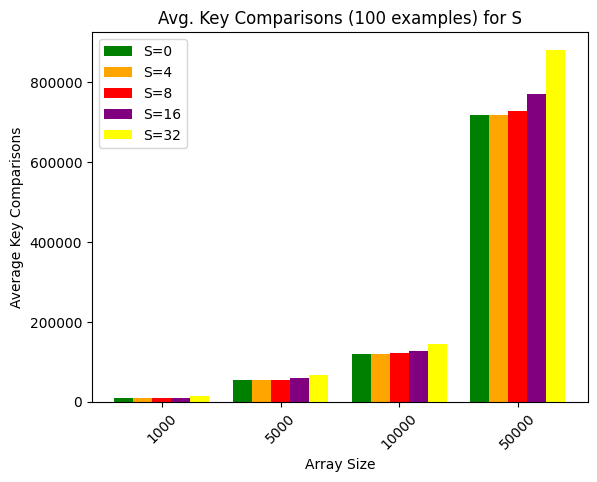

In [39]:
categories = [f"{d["size"]}" for d in dataset_1]

x = np.arange(len(categories))
width = 0.8 / len(tests)

print(f"| S | {" | ".join(categories)} |")
print(f"|:---|{':---|' * len(categories)}")
for i, test in enumerate(tests_1):
    offset = (i - (len(tests_1) - 1) / 2) * width
    plt.bar(x + offset, test['comparisons'], width, label=f'S={test["S"]}', color=test['color'])
    comparisons_str = [str(comp) for comp in test['comparisons']]
    print(f"| {test['S']} | {' | '.join(comparisons_str)} |")

plt.xlabel('Array Size')
plt.ylabel('Average Key Comparisons')
plt.title('Avg. Key Comparisons (100 examples) for S')
plt.xticks(x, categories)
plt.xticks(rotation=45)
plt.legend()
plt.show()


| S | 1000 | 5000 | 10000 | 50000 |
|:---|:---|:---|:---|:---|
| 0 | 8707.98 | 55220.45 | 120452.05 | 718182.0 |
| 4 | 8766.68 | 55256.63 | 120506.52 | 718390.61 |
| 8 | 9122.33 | 55754.95 | 121498.46 | 728991.37 |
| 16 | 10314.56 | 58536.1 | 127082.01 | 769740.26 |
| 32 | 13355.87 | 66762.53 | 143596.67 | 881129.68 |

In [9]:
tests_2 = init_test([
    (0, "green"), # From here onwards, green will be normal merge sort.
    (4, "orange"),
    (8, "red"),
    (16, "purple"),
    (32, "yellow"),
])

threads = []
for i, test in enumerate(tests_2):
    thread = threading.Thread(target=run_test, args=(test, dataset_2,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()


| S | 100000 | 500000 | 1000000 | 5000000 | 10000000 |
|:---|:---|:---|:---|:---|:---|
| 0 | 1536495.0 | 8836385.0 | 18674723.0 | 105051834.0 | 220098497.0 |
| 4 | 1537095.0 | 8863758.0 | 18728360.0 | 105111731.0 | 220221098.0 |
| 8 | 1558357.0 | 9037408.0 | 19073861.0 | 105555895.0 | 221107282.0 |
| 16 | 1640075.0 | 9614676.0 | 20225592.0 | 108210097.0 | 226418097.0 |
| 32 | 1862461.0 | 11093973.0 | 23187994.0 | 116159684.0 | 242314167.0 |


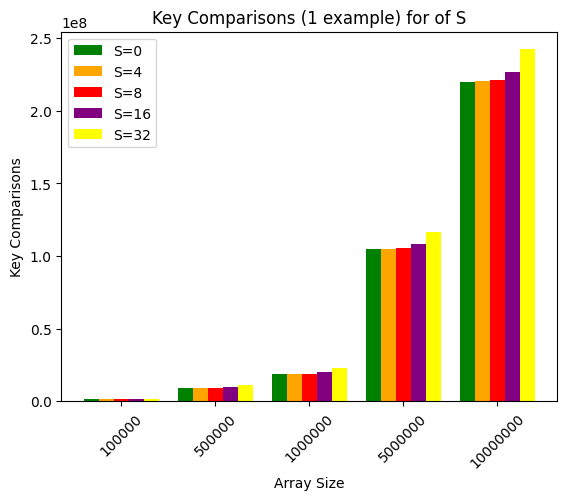

In [27]:
categories = [f"{d["size"]}" for d in dataset_2]

x = np.arange(len(categories))
width = 0.8 / len(tests_2)

print(f"| S | {" | ".join(categories)} |")
print(f"|:---|{':---|' * len(categories)}")
for i, test in enumerate(tests_2):
    offset = (i - (len(tests_2) - 1) / 2) * width
    plt.bar(x + offset, test['comparisons'], width, label=f'S={test["S"]}', color=test['color'])
    comparisons_str = [str(comp) for comp in test['comparisons']]
    print(f"| {test['S']} | {' | '.join(comparisons_str)} |")

plt.xlabel('Array Size')
plt.ylabel('Key Comparisons')
plt.title('Key Comparisons (1 example) for of S')
plt.xticks(x, categories)
plt.xticks(rotation=45)
plt.legend()
plt.show()


| S | 100000 | 500000 | 1000000 | 5000000 | 10000000 |
|:---|:---|:---|:---|:---|:---|
| 0 | 1536495.0 | 8836385.0 | 18674723.0 | 105051834.0 | 220098497.0 |
| 4 | 1537095.0 | 8863758.0 | 18728360.0 | 105111731.0 | 220221098.0 |
| 8 | 1558357.0 | 9037408.0 | 19073861.0 | 105555895.0 | 221107282.0 |
| 16 | 1640075.0 | 9614676.0 | 20225592.0 | 108210097.0 | 226418097.0 |
| 32 | 1862461.0 | 11093973.0 | 23187994.0 | 116159684.0 | 242314167.0 |

> Using different sizes of input datasets, study how to determine an optimal value of S for the best performance of this hybrid algorithm.

Based on the above plots, `S>4` requires more key comparisons than normal merge sort. 

**As S -> inf**, the algorithm approaches to insertion sort.

For `0 < S <= 4`, it requires about the same amount of key comparisons.

**As S -> 0**, the algorithm approaches to normal merge sort.

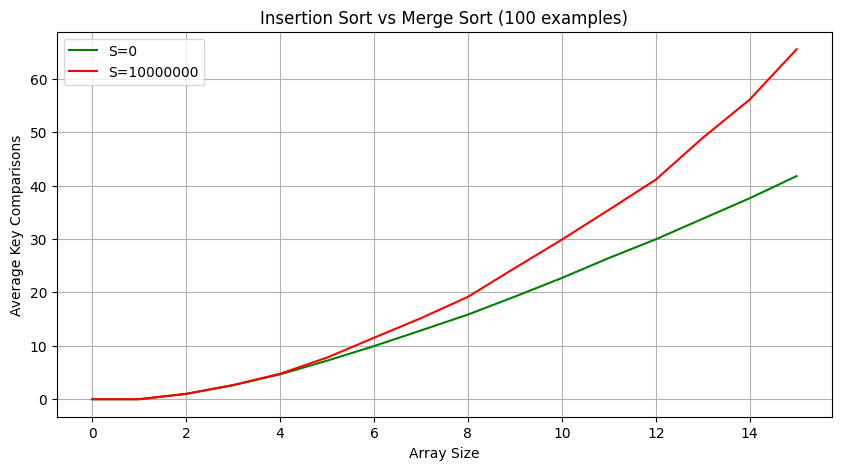

In [36]:
analysis_dataset_1 = generate_data([
  (x, 100) for x in range(0, 16)
])
analysis_tests_1 = init_test([
    (0, "green"), # S = 0 is normal merge sort.
    (10000000, "red"), # S -> Inf is insertion sort. Its essentially insertion sort lol.
])

threads = []
for i, test in enumerate(analysis_tests_1):
    thread = threading.Thread(target=run_test, args=(test, analysis_dataset_1,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()

# Plot the results
plt.figure(figsize=(10, 5))

for test in analysis_tests_1:
    plt.plot(test['X'], test['comparisons'], label=f"S={test['S']}", color=test['color'])

plt.grid(True)
plt.xlabel('Array Size')
plt.ylabel('Average Key Comparisons')
plt.title('Insertion Sort vs Merge Sort (100 examples)')
plt.legend()
plt.show()



If we go by **key comparisons**, we see no significant difference for `S <= 4`, however, insertion sort starts to shoot up when `S > 4` . 

As hinted in the lab,
> In Mergesort, when the sizes of subarrays are small, **the overhead of many recursive calls makes the algorithm inefficient**. Therefore, in real use, we often combine Mergesort with Insertion Sort to come up with a hybrid sorting algorithm for better efficiency. The idea is to set a small integer S as a threshold for the size of subarrays. Once the size of a subarray in a recursive call of Mergesort is less than or equal to S, the algorithm will switch to Insertion Sort, which is efficient for small-sized input.

Let's explore this overhead in terms of CPU time.


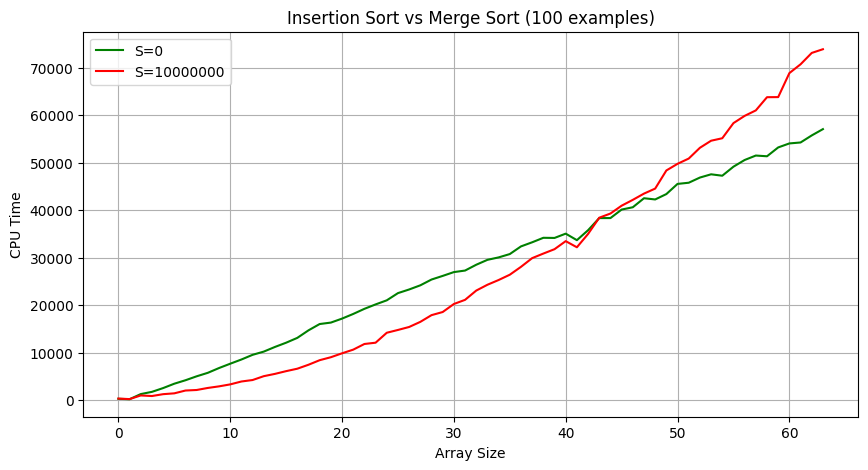

In [37]:
analysis_dataset_1 = generate_data([
  (x, 100) for x in range(0, 64)
])
analysis_tests_1 = init_test([
    (0, "green"), # S = 0 is normal merge sort.
    (10000000, "red"), # S -> Inf is insertion sort. Its essentially insertion sort lol.
])

threads = []
for i, test in enumerate(analysis_tests_1):
    thread = threading.Thread(target=run_test, args=(test, analysis_dataset_1,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()

# Plot the results
plt.figure(figsize=(10, 5))

for test in analysis_tests_1:
    plt.plot(test['X'], test['duration'], label=f"S={test['S']}", color=test['color'])

plt.grid(True)
plt.xlabel('Array Size')
plt.ylabel('CPU Time')
plt.title('Insertion Sort vs Merge Sort (100 examples)')
plt.legend()
plt.show()


Here, insertion sort surpasses merge sort after array size 40.

Perhaps `S = 40`?

In [40]:
confirmation_tests_1 = init_test([
    (0, "green"), # From here onwards, green will be normal merge sort.
    (4, "orange"),
    (8, "red"),
    (16, "purple"),
    (40, "yellow"),
])

threads = []
for i, test in enumerate(confirmation_tests_1):
    # Use back dataset 1
    thread = threading.Thread(target=run_test, args=(test, dataset_1,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()


| S | 1000 | 5000 | 10000 | 50000 |
|:---|:---|:---|:---|:---|
| 0 | 8707.98 | 55220.45 | 120452.05 | 718182.0 |
| 4 | 8766.68 | 55256.63 | 120506.52 | 718390.61 |
| 8 | 9122.33 | 55754.95 | 121498.46 | 728991.37 |
| 16 | 10314.56 | 58536.1 | 127082.01 | 769740.26 |
| 40 | 13355.87 | 86805.47 | 183698.78 | 881129.68 |


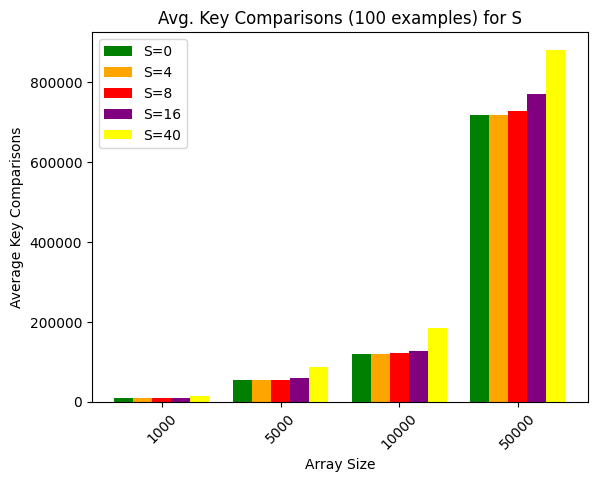

In [41]:
categories = [f"{d["size"]}" for d in dataset_1]

x = np.arange(len(categories))
width = 0.8 / len(tests)

print(f"| S | {" | ".join(categories)} |")
print(f"|:---|{':---|' * len(categories)}")
for i, test in enumerate(confirmation_tests_1):
    offset = (i - (len(confirmation_tests_1) - 1) / 2) * width
    plt.bar(x + offset, test['comparisons'], width, label=f'S={test["S"]}', color=test['color'])
    comparisons_str = [str(comp) for comp in test['comparisons']]
    print(f"| {test['S']} | {' | '.join(comparisons_str)} |")

plt.xlabel('Array Size')
plt.ylabel('Average Key Comparisons')
plt.title('Avg. Key Comparisons (100 examples) for S')
plt.xticks(x, categories)
plt.xticks(rotation=45)
plt.legend()
plt.show()

| S | 1000 | 5000 | 10000 | 50000 |
|:---|:---|:---|:---|:---|
| 0 | 8707.98 | 55220.45 | 120452.05 | 718182.0 |
| 4 | 8766.68 | 55256.63 | 120506.52 | 718390.61 |
| 8 | 9122.33 | 55754.95 | 121498.46 | 728991.37 |
| 16 | 10314.56 | 58536.1 | 127082.01 | 769740.26 |
| 40 | 13355.87 | 86805.47 | 183698.78 | 881129.68 |

| S | 1000 | 5000 | 10000 | 50000 |
|:---|:---|:---|:---|:---|
| 0 | 1198772.51 | 24332031.2 | 79042258.37 | 2338891308.32 |
| 4 | 930430.84 | 16066709.97 | 87199892.53 | 2067680737.52 |
| 8 | 877889.55 | 8802398.34 | 78558240.4 | 1385435895.84 |
| 16 | 886337.95 | 8567300.86 | 55113277.5 | 1546789875.44 |
| 40 | 1010695.02 | 27447161.33 | 80595953.29 | 2146028879.08 |


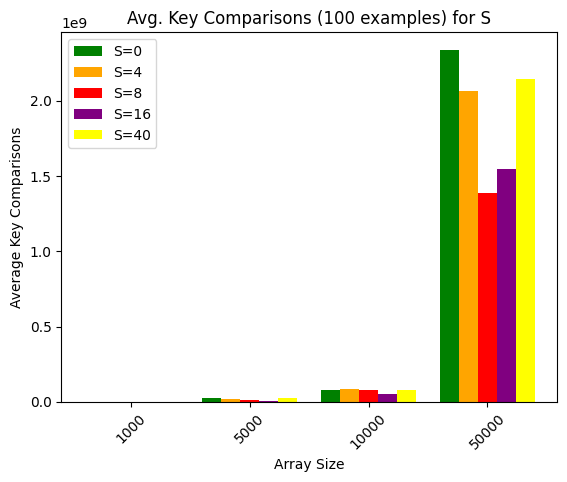

In [ ]:
categories = [f"{d["size"]}" for d in dataset_1]

x = np.arange(len(categories))
width = 0.8 / len(tests)

print(f"| S | {" | ".join(categories)} |")
print(f"|:---|{':---|' * len(categories)}")
for i, test in enumerate(confirmation_tests_1):
    offset = (i - (len(confirmation_tests_1) - 1) / 2) * width
    plt.bar(x + offset, test['duration'], width, label=f'S={test["S"]}', color=test['color'])
    comparisons_str = [str(comp) for comp in test['duration']]
    print(f"| {test['S']} | {' | '.join(comparisons_str)} |")

plt.xlabel('Array Size')
plt.ylabel('Average Duration')
plt.title('Avg. Duration (100 examples) for S')
plt.xticks(x, categories)
plt.xticks(rotation=45)
plt.legend()
plt.show()

| S | 1000 | 5000 | 10000 | 50000 |
|:---|:---|:---|:---|:---|
| 0 | 1198772.51 | 24332031.2 | 79042258.37 | 2338891308.32 |
| 4 | 930430.84 | 16066709.97 | 87199892.53 | 2067680737.52 |
| 8 | 877889.55 | 8802398.34 | 78558240.4 | 1385435895.84 |
| 16 | 886337.95 | 8567300.86 | 55113277.5 | 1546789875.44 |
| 40 | 1010695.02 | 27447161.33 | 80595953.29 | 2146028879.08 |

# (d) Compare with original Mergesort: Implement the original version of Mergesort (as learnt in lecture). Compare its performance against the above hybrid algorithm in terms of the number of key comparisons and CPU times on the dataset with 10 million integers. You can use the optimal value of S obtained in (c) for this task.

Using `S=40`.


In [44]:
confirmation_tests_2 = init_test([
    (0, "green"), # From here onwards, green will be normal merge sort.
    (4, "orange"),
    (8, "red"),
    (16, "purple"),
    (40, "yellow"),
])

threads = []
for i, test in enumerate(confirmation_tests_2):
    # Use back dataset 2
    thread = threading.Thread(target=run_test, args=(test, dataset_2,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()

| S | 100000 | 500000 | 1000000 | 5000000 | 10000000 |
|:---|:---|:---|:---|:---|:---|
| 0 | 1536495.0 | 8836385.0 | 18674723.0 | 105051834.0 | 220098497.0 |
| 4 | 1537095.0 | 8863758.0 | 18728360.0 | 105111731.0 | 220221098.0 |
| 8 | 1558357.0 | 9037408.0 | 19073861.0 | 105555895.0 | 221107282.0 |
| 16 | 1640075.0 | 9614676.0 | 20225592.0 | 108210097.0 | 226418097.0 |
| 40 | 1862461.0 | 11093973.0 | 23187994.0 | 135630374.0 | 281236740.0 |


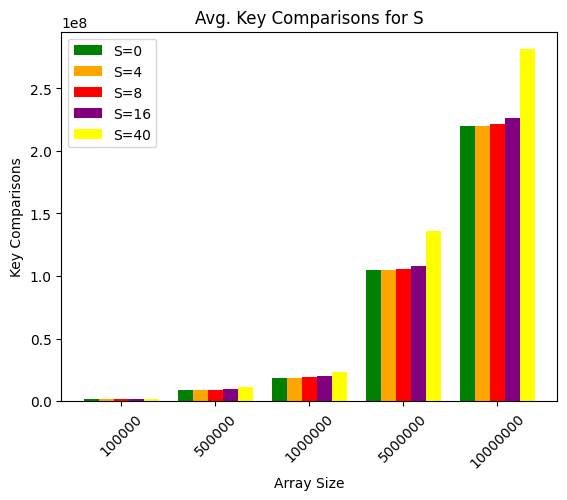

In [45]:
categories = [f"{d["size"]}" for d in dataset_2]

x = np.arange(len(categories))
width = 0.8 / len(tests)

print(f"| S | {" | ".join(categories)} |")
print(f"|:---|{':---|' * len(categories)}")
for i, test in enumerate(confirmation_tests_2):
    offset = (i - (len(confirmation_tests_2) - 1) / 2) * width
    plt.bar(x + offset, test['comparisons'], width, label=f'S={test["S"]}', color=test['color'])
    comparisons_str = [str(comp) for comp in test['comparisons']]
    print(f"| {test['S']} | {' | '.join(comparisons_str)} |")

plt.xlabel('Array Size')
plt.ylabel('Key Comparisons')
plt.title('Avg. Key Comparisons for S')
plt.xticks(x, categories)
plt.xticks(rotation=45)
plt.legend()
plt.show()

| S | 100000 | 500000 | 1000000 | 5000000 | 10000000 |
|:---|:---|:---|:---|:---|:---|
| 0 | 871143250.0 | 5866087208.0 | 11380064250.0 | 72909025625.0 | 136815195084.0 |
| 4 | 870780125.0 | 4789811833.0 | 9585419834.0 | 66817442500.0 | 140555826042.0 |
| 8 | 975681541.0 | 4795074709.0 | 9566769125.0 | 61993517083.0 | 137157801167.0 |
| 16 | 717550583.0 | 4671663834.0 | 10412841750.0 | 61873952625.0 | 137637537209.0 |
| 40 | 790542125.0 | 4541384083.0 | 10533051041.0 | 69237440458.0 | 140046748791.0 |


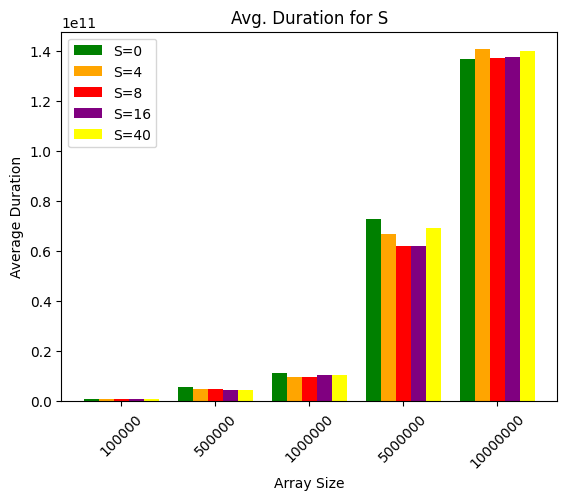

In [46]:
categories = [f"{d["size"]}" for d in dataset_2]

x = np.arange(len(categories))
width = 0.8 / len(tests)

print(f"| S | {" | ".join(categories)} |")
print(f"|:---|{':---|' * len(categories)}")
for i, test in enumerate(confirmation_tests_2):
    offset = (i - (len(confirmation_tests_2) - 1) / 2) * width
    plt.bar(x + offset, test['duration'], width, label=f'S={test["S"]}', color=test['color'])
    comparisons_str = [str(comp) for comp in test['duration']]
    print(f"| {test['S']} | {' | '.join(comparisons_str)} |")

plt.xlabel('Array Size')
plt.ylabel('Average Duration')
plt.title('Avg. Duration for S')
plt.xticks(x, categories)
plt.xticks(rotation=45)
plt.legend()
plt.show()

**What's with the time variability?**

Finding S by time benchmarking is prone to inaccuracies. Due to:
- Dependent on device
- Dependent on implementation. Insertion sort implementation copies and does inplace sorting so it's faster.
- Dependent on language
- Dependent on what other processes are running

... too many variables so it's going to be highly variable.

